In [ ]:
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# Step 1: Import Libraries and Load the Dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from a CSV file
df = pd.read_csv('/content/drive/MyDrive/yuksekTez/airline_dataset/clean_text.csv')

Mounted at /content/drive


In [ ]:
with strategy.scope():
  # Step 2: Preprocess the Dataset
  tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
  tokenizer.fit_on_texts(df["text"])
  vocab_size = len(tokenizer.word_index) + 1
  sequences = tokenizer.texts_to_sequences(df["text"])
  maxlen = 100
  padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding="post", truncating="post")
  labels = pd.get_dummies(df["airline_sentiment"]).values

In [ ]:
# Step 3: Split the Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.25, random_state=42)


In [ ]:
print("Training Class Distribution:", np.sum(y_train, axis=0))
print("Validation Class Distribution:", np.sum(y_test, axis=0))

In [ ]:
# Step 4: Building the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.1

for epoch in range(100):
    lr = 0.001
    new_lr = lr_schedule(epoch, lr)
    print(f"Epoch {epoch+1} - Learning Rate: {new_lr}")

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

with strategy.scope():
    # Define the model
    model2 = Sequential()
    model2.add(Embedding(vocab_size, 64, input_length=maxlen))  # Increased embedding size
    model2.add(LSTM(128, return_sequences=True))  # Single LSTM layer
    model2.add(Dropout(0.3))  # Dropout layer
    model2.add(LSTM(64))  # Additional LSTM layer
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))  # Increased dropout rate
    model2.add(BatchNormalization())
    model2.add(Dense(3, activation='softmax'))


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 64)           1009280   
                                                                 
 lstm_9 (LSTM)               (None, 100, 128)          98816     
                                                                 
 dropout_5 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)             

In [ ]:
# Step 5: Compiling the model and defining optimizer etc.

from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 64)           1009280   
                                                                 
 lstm_9 (LSTM)               (None, 100, 128)          98816     
                                                                 
 dropout_5 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)             

In [ ]:
with strategy.scope():
  # Step 6: Train the Model
  history = model2.fit(X_train, y_train,
                         epochs=100,
                         batch_size=64,
                         validation_split=0.1,
                         callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
155/155 [==============================] - 19s 70ms/step - loss: 0.9600 - accuracy: 0.5862 - val_loss: 0.9279 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - 5s 31ms/step - loss: 0.9217 - accuracy: 0.6235 - val_loss: 0.9280 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - 5s 34ms/step - loss: 0.9203 - accuracy: 0.6235 - val_loss: 0.9290 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 4/100
155/155 [==============================] - 5s 34ms/step - loss: 0.9205 - accuracy: 0.6235 - val_loss: 0.9278 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 5/100
155/155 [==============================] - 5s 32ms/step - loss: 0.9204 - accuracy: 0.6235 - val_loss: 0.9280 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 6/100
155/155 [==============================] - 5s 32ms/step - loss: 0.9200 - accuracy: 0.6235 - val_loss: 0.9292 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 7/100
155/155 [==============================] - 5s

In [ ]:
# Step 7: Evaluate the Model on the Testing Set
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

115/115 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      2340
           1       0.00      0.00      0.00       738
           2       0.00      0.00      0.00       582

    accuracy                           0.64      3660
   macro avg       0.21      0.33      0.26      3660
weighted avg       0.41      0.64      0.50      3660

[[2340    0    0]
 [ 738    0    0]
 [ 582    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


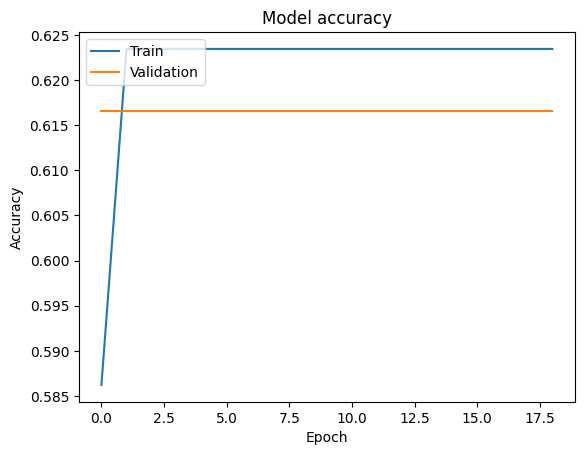

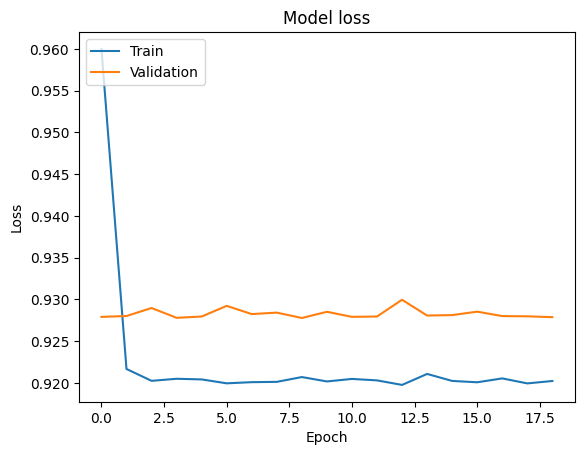

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curve(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming 'history' is the variable storing your model's training history
plot_learning_curve(history)

In [ ]:
y_pred_probs = model2.predict(X_test)  # Print for the first 10 samples
print("Predicted Probabilities:")
print(y_pred_probs)


115/115 [==============================] - 2s 10ms/step
Predicted Probabilities:
[[0.62288827 0.21371837 0.16339338]
 [0.62288827 0.21371837 0.16339338]
 [0.62288827 0.21371837 0.16339338]
 ...
 [0.62288827 0.21371837 0.16339338]
 [0.62288827 0.21371837 0.16339338]
 [0.62288827 0.21371837 0.16339338]]


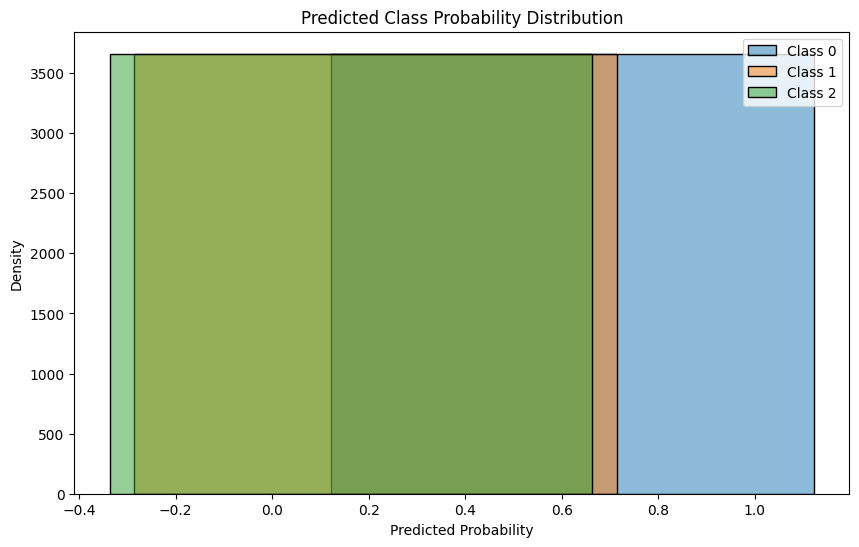

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

for class_idx in range(3):  # Assuming you have 3 classes
    sns.histplot(y_pred_probs[:, class_idx], label=f'Class {class_idx}', kde=True)

plt.title('Predicted Class Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
most_probable_classes = np.argmax(y_pred_probs, axis=1)
class_counts = np.bincount(most_probable_classes, minlength=3)  # Assuming 3 classes
print("Most Probable Class Counts:", class_counts)


Most Probable Class Counts: [3660    0    0]


In [ ]:
print("y_test shape:", y_test.shape)
print("Sample y_test values:", y_test[:5])  # Print the first few samples

y_test shape: (3660,)
Sample y_test values: [2 0 0 1 0]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert y_test to one-hot encoded format
y_test_onehot = np.eye(3)[y_test]

# Evaluate model's performance
accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), y_pred_labels)
classification_rep = classification_report(np.argmax(y_test_onehot, axis=1), y_pred_labels)
confusion_mat = confusion_matrix(np.argmax(y_test_onehot, axis=1), y_pred_labels)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)



Accuracy: 0.639344262295082
Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      2340
           1       0.00      0.00      0.00       738
           2       0.00      0.00      0.00       582

    accuracy                           0.64      3660
   macro avg       0.21      0.33      0.26      3660
weighted avg       0.41      0.64      0.50      3660

Confusion Matrix:
 [[2340    0    0]
 [ 738    0    0]
 [ 582    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
